In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp, solve_bvp
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt
from numba import jit

In [4]:
def generate_fishing_grounds(n_grounds = 10, x_max = 100, y_max = 100):
    return np.random.rand(n_grounds, 2) * np.array([x_max, y_max])

In [5]:
def generate_ships(n_ships = 10, x_max = 100, y_max = 100):
    return np.random.rand(n_ships, 2) * np.array([x_max, y_max])

In [6]:
def generate_ships_at_harbor(h, n_ships = 10):
    """
    Returns an n_ships x 2 array of ships at the harbor h
    """
    return np.array([h for _ in range(n_ships)])

In [7]:
def calculate_ship_distance_from_grounds(ships, grounds):
    return np.linalg.norm(ships[:, np.newaxis] - grounds, axis=2)

In [8]:
def d_matrix(ships, grounds):
    # Vectorized difference calculation
    differences = grounds - ships[:, np.newaxis]
    distances = np.linalg.norm(differences, axis=2, keepdims=True)
    return differences / (distances + 1e-6)  # Adding small value to avoid division by zero

In [9]:
def ship_ground_gaussians(ships, grounds, alpha):
    distances = np.linalg.norm(ships[:, np.newaxis] - grounds, axis=2)
    return np.exp(-alpha * distances**2)

In [10]:
def calculate_ship_distance_from_ships(ships):
    return np.linalg.norm(ships[:, np.newaxis] - ships, axis=2)

In [11]:
def harbor_attraction(U, ships, h):
    diff = h - ships
    diff_norm = np.linalg.norm(diff, axis=1, keepdims=True) + 1e-6
    return U[:, -2, np.newaxis] * (diff / diff_norm)

In [12]:
def attraction_matrix(U, G, D, F):
    F_reshaped = F.reshape(1, -1, 1)
    return U[:, :-2, None] * G[:, :, None] * D * F_reshaped

In [13]:
def calculate_F_prime(t, F, G, rate):
    G_sum = np.sum(G, axis=0)
    return -rate * F * G_sum

In [76]:
def calculate_x_prime(t, x, F, A, U, H):
    # sum the attraction matrix over all grounds and harbor
    A_sum = np.sum(A, axis=1).reshape(-1, 2) + H

    A_sum /= np.linalg.norm(A_sum) + 1e-6

    # Reshape U[:,-2] to have an extra dimension
    U_reshaped = U[:,-1].reshape(-1, 1)

    return U_reshaped * A_sum

In [80]:
def ode(t, y, params):
    alpha, rate, U, grounds, h, x_size, F_size, x_shape = params
    x = y[:x_size].reshape(x_shape)  # reshape x back to its original shape
    F = y[x_size:x_size+F_size]

    # Calculate G matrix
    G = ship_ground_gaussians(x, grounds, alpha)

    # Calculate D matrix
    D = d_matrix(x, grounds)

    # Calculate A matrix
    A = attraction_matrix(U, G, D, F)

    # Calculate H
    H = harbor_attraction(U, x, h)

    # Calculate F' (you'll need to replace this with your actual calculation)
    F_prime = calculate_F_prime(t, F, G, rate)

    # Calculate x' (you'll need to replace this with your actual calculation)
    x_prime = calculate_x_prime(t, x, F, A, U, H)

    # Flatten x_prime and F_prime and concatenate them into a single 1D array
    return np.concatenate((x_prime.flatten(), F_prime.flatten()))

In [99]:
alpha = .001
rate = .005

# h is the harbor position
h = np.array([50, 0])

# grounds = generate_fishing_grounds()
# ships = generate_ships(20)

# initialize U as all ones
U = np.ones((ships.shape[0], grounds.shape[0] + 2))

# set the last column of U to 0
U[:,-2] = 0

# initialize F as all ones
F = np.ones(grounds.shape[0])

# x is ship positions
x = ships

# Get the sizes of x and F before flattening
x_size = np.prod(x.shape)
F_size = np.prod(F.shape)

# Get the original shape of x
x_shape = x.shape

# Flatten x and F into a single 1D array
y0 = np.concatenate((x.flatten(), F))

params = (alpha, rate, U, grounds, h, x_size, F_size, x_shape)

sol = solve_ivp(ode, [0, 200], y0, args=(params,), t_eval=np.linspace(0, 200, 200))


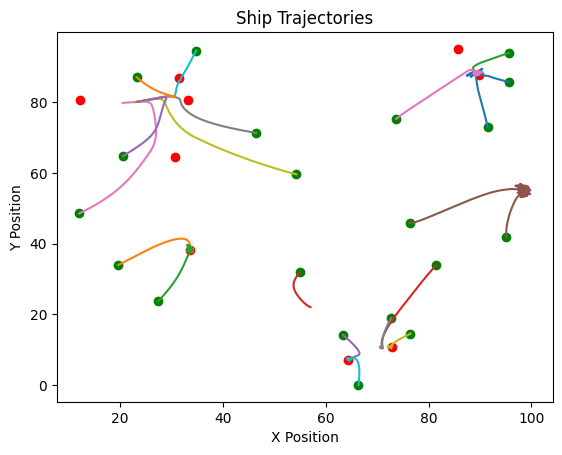

In [100]:
# Extract ship positions from the solution
ship_positions = sol.y[:x_size].reshape(x_shape + (-1,))

# Plot the grounds
plt.scatter(grounds[:, 0], grounds[:, 1], c='red', label='Grounds')

# Plot the starting points of the ships
plt.scatter(ship_positions[:, 0, 0], ship_positions[:, 1, 0], c='green', label='Starting points')

# Plot the trajectory of each ship
for i in range(ship_positions.shape[0]):
    plt.plot(ship_positions[i, 0, :], ship_positions[i, 1, :], label=f'Ship {i+1}')

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Ship Trajectories')
plt.show()